# Causation vs. correlation experiments

Roughly: 
1. initialize a hypothesis h : causation -> correlation with a simple linear model. Generate a causal diagram for the purposes here.
2. Translate the causation feature using the known correlations, and recompute the linear model.
3. Test it with a real causal diagram, courtesy of Sokwoo.
4. ???

Actually, h : causation -> coefficient of determination, i.e. h : V x V -> {0,1} x ??? -> [0,1].



In [127]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import random
import scipy
from IPython import display
import math
import networkx as nx

In [128]:
cityscore_raw = pd.read_csv('cityscore.csv', header=0, skiprows = 0, dtype=None)
water = pd.read_csv('water.csv', header=0, skiprows = 0, dtype=None)
civil = pd.read_csv('civil.csv', header=0, skiprows = 0, dtype=None)
jobapp = pd.read_csv('jobapp.csv', header=0, skiprows = 0, dtype=None)
collisions = pd.read_csv('collisions.csv', header=0, skiprows = 0, dtype=None)
# v311 = pd.read_csv('311.csv', header=0, skiprows = 0, dtype=None) # too big

/Users/Josh/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The CityScore dataset comes from https://data.boston.gov/dataset/cityscore. It is nice and numeric, but we need to shape it to look like a time-series.

In [129]:
cityscore_raw

CTY_SCR_NAME  CTY_SCR_NBR_DY_01  \
0                       HOMICIDES (TREND)           0.000000   
1      CITY SERVICES SATISFACTION SURVEYS           2.000000   
2                       BFD RESPONSE TIME           0.845133   
3                       EMS RESPONSE TIME           5.775000   
4             311 CALL CENTER PERFORMANCE           0.936133   
5                           BFD INCIDENTS         230.000000   
6                           EMS INCIDENTS         284.000000   
7                      GRAFFITI ON-TIME %           1.000000   
8                  MISSED TRASH ON-TIME %           0.937500   
9             PARKS MAINTENANCE ON-TIME %           0.878788   
10                      POTHOLE ON-TIME %           0.750000   
11            SIGN INSTALLATION ON-TIME %           1.000000   
12                SIGNAL REPAIR ON-TIME %           0.555556   
13                  STREETLIGHT ON-TIME %           0.761905   
14             TREE MAINTENANCE ON-TIME %           0.941176   
15     CITY SERVICES SATISFACTION SURVEYS           3.666666   
16     CITY SERVICES SATISFACTION SURVEYS           3.444444   
17     CITY SERVICES SATISFACTION SURVEYS           2.857142   
18            311 CALL CENTER PERFORMANCE           0.822687   
19                          BFD INCIDENTS         265.000000   
20                          EMS INCIDENTS         357.000000   
21                     GRAFFITI ON-TIME %           1.000000   
22                 MISSED TRASH ON-TIME %           0.945946   
23            PARKS MAINTENANCE ON-TIME %           0.769231   
24                      POTHOLE ON-TIME %           0.866667   
25            SIGN INSTALLATION ON-TIME %                NaN   
26                SIGNAL REPAIR ON-TIME %           0.875000   
27                  STREETLIGHT ON-TIME %           0.687500   
28                          PART 1 CRIMES          42.000000   
29                      HOMICIDES (TREND)           0.000000   
...                                   ...                ...   
13829                       BFD INCIDENTS         217.000000   
13830                       EMS INCIDENTS         352.000000   
13831                  GRAFFITI ON-TIME %                NaN   
13832              MISSED TRASH ON-TIME %           0.935484   
13833         PARKS MAINTENANCE ON-TIME %           0.666667   
13834                   POTHOLE ON-TIME %           1.000000   
13835         SIGN INSTALLATION ON-TIME %           1.000000   
13836             SIGNAL REPAIR ON-TIME %           0.760000   
13837               STREETLIGHT ON-TIME %           0.200000   
13838          TREE MAINTENANCE ON-TIME %           1.000000   
13839                   BFD RESPONSE TIME           0.810427   
13840                   EMS RESPONSE TIME           7.325000   
13841                   HOMICIDES (TREND)           0.000000   
13842                   SHOOTINGS (TREND)           0.000000   
13843                   STABBINGS (TREND)           1.000000   
13844                       PART 1 CRIMES          22.000000   
13845                       LIBRARY USERS        7482.000000   
13846                       BFD INCIDENTS         193.000000   
13847  311 CONSTITUENT EXPERIENCE SURVEYS           4.000000   
13848                       EMS INCIDENTS         316.000000   
13849                  GRAFFITI ON-TIME %           0.545454   
13850              MISSED TRASH ON-TIME %           1.000000   
13851         PARKS MAINTENANCE ON-TIME %           0.666667   
13852                   POTHOLE ON-TIME %           0.354839   
13853         SIGN INSTALLATION ON-TIME %           1.000000   
13854             SIGNAL REPAIR ON-TIME %           1.000000   
13855               STREETLIGHT ON-TIME %           0.421053   
13856          TREE MAINTENANCE ON-TIME %                NaN   
13857              ON-TIME PERMIT REVIEWS           0.444444   
13858                   EMS RESPONSE TIME           7.358333   

       CTY_SCR_NBR_DY_02  CTY_SCR_NBR_WK_01  CTY_SCR_NBR_WK_

In [130]:
# pivot the table above with column values from CTY_SCR_NAME
cityscore = cityscore_raw.pivot(index='ETL_LOAD_DATE', columns='CTY_SCR_NAME',values='CTY_SCR_WEEK')
cityscore

CTY_SCR_NAME         311 CALL CENTER PERFORMANCE  \
ETL_LOAD_DATE                                      
2016-01-15 00:00:00                     0.939047   
2016-01-18 00:00:00                     0.943842   
2016-01-19 00:00:00                     0.962992   
2016-01-20 00:00:00                     0.963102   
2016-01-21 00:00:00                     0.978952   
2016-01-22 00:00:00                     0.980779   
2016-01-25 00:00:00                     0.982268   
2016-01-26 00:00:00                     0.981040   
2016-01-27 00:00:00                     0.993167   
2016-01-28 00:00:00                     0.995739   
2016-01-29 00:00:00                     0.997925   
2016-02-01 00:00:00                     1.002290   
2016-02-02 00:00:00                     1.009193   
2016-02-03 00:00:00                     1.019408   
2016-02-04 00:00:00                     1.019554   
2016-02-05 00:00:00                     1.025526   
2016-02-08 00:00:00                     1.021731   
2016-02-09 00:00:00                     1.025162   
2016-02-10 00:00:00                     1.022681   
2016-02-11 00:00:00                     1.022973   
2016-02-12 00:00:00                     1.020879   
2016-02-15 00:00:00                     0.976480   
2016-02-16 00:00:00                     0.958279   
2016-02-17 00:00:00                     0.951543   
2016-02-18 00:00:00                     0.943918   
2016-02-19 00:00:00                     0.948045   
2016-02-22 00:00:00                     0.993818   
2016-02-23 00:00:00                     1.006400   
2016-02-24 00:00:00                     1.019831   
2016-02-25 00:00:00                     1.021035   
...                                          ...   
2018-05-24 00:00:00                     0.970866   
2018-05-25 00:00:00                     0.973283   
2018-05-28 00:00:00                     0.971938   
2018-05-29 00:00:00                     0.973516   
2018-05-30 00:00:00                     0.976542   
2018-05-31 00:00:00                     0.977538   
2018-06-01 00:00:00                     0.980720   
2018-06-04 00:00:00                     0.974172   
2018-06-05 00:00:00                     0.975712   
2018-06-06 00:00:00                     0.971195   
2018-06-07 00:00:00                     0.969089   
2018-06-08 00:00:00                     0.970720   
2018-06-11 00:00:00                     0.964198   
2018-06-12 00:00:00                     0.966266   
2018-06-13 00:00:00                     0.972135   
2018-06-14 00:00:00                     0.970237   
2018-06-15 00:00:00                     0.967955   
2018-06-18 00:00:00                          NaN   
2018-06-19 00:00:00                     0.910937   
2018-06-20 00:00:00                     0.907467   
2018-06-21 00:00:00                     0.904941   
2018-06-22 00:00:00                     0.907931   
2018-06-25 00:00:00                     0.897885   
2018-06-26 00:00:00                     0.961545   
2018-06-27 00:00:00                     0.957250   
2018-06-28 00:00:00                     0.957029   
2018-06-29 00:00:00                     0.958030   
2018-07-02 00:00:00                     0.952259   
2018-07-03 00:00:00                     0.938240   
2018-07-04 00:00:00                     0.936176   

CTY_SCR_NAME         311 CONSTITUENT EXPERIENCE SURVEYS  BFD INCIDENTS  \
ETL_LOAD_DATE                                                            
2016-01-15 00:00:00                                 NaN       1.247173   
2016-01-18 00:00:00                                 NaN       1.280044   
2016-01-19 00:00:00                                 NaN       1.286465   
2016-01-20 00:00:00                                 NaN       1.297427   
2016-01-21 00:00:00                                 NaN       1.283027   
2016-01-22 00:00:00                                 NaN       1.285570   
2016-01-25 00:00:00                                 NaN       1.275504   
2016-01-26 00:00:00                                 NaN  

In [131]:
# define correlation matrix for cityscore
Corr_cityscore = cityscore.corr()
print('Dimensions of Corr_cityscore: ', Corr_cityscore.shape)
Corr_cityscore

# are some of these variables as "adjectives"? not as *nouns*

Dimensions of Corr_cityscore:  (22, 22)


CTY_SCR_NAME                        311 CALL CENTER PERFORMANCE  \
CTY_SCR_NAME                                                      
311 CALL CENTER PERFORMANCE                            1.000000   
311 CONSTITUENT EXPERIENCE SURVEYS                    -0.046539   
BFD INCIDENTS                                          0.380747   
BFD RESPONSE TIME                                      0.098502   
BPS ATTENDANCE                                         0.282059   
CITY SERVICES SATISFACTION SURVEYS                     0.093426   
EMS INCIDENTS                                          0.028325   
EMS RESPONSE TIME                                      0.235695   
GRAFFITI ON-TIME %                                     0.141112   
HOMICIDES (TREND)                                      0.191240   
LIBRARY USERS                                          0.467538   
MISSED TRASH ON-TIME %                                 0.292583   
ON-TIME PERMIT REVIEWS                                 0.207133   
PARKS MAINTENANCE ON-TIME %                            0.001002   
PART 1 CRIMES                                          0.002781   
POTHOLE ON-TIME %                                      0.181249   
SHOOTINGS (TREND)                                     -0.058349   
SIGN INSTALLATION ON-TIME %                            0.194438   
SIGNAL REPAIR ON-TIME %                               -0.182817   
STABBINGS (TREND)                                     -0.108090   
STREETLIGHT ON-TIME %                                 -0.006755   
TREE MAINTENANCE ON-TIME %                            -0.165917   

CTY_SCR_NAME                        311 CONSTITUENT EXPERIENCE SURVEYS  \
CTY_SCR_NAME                                                             
311 CALL CENTER PERFORMANCE                                  -0.046539   
311 CONSTITUENT EXPERIENCE SURVEYS                            1.000000   
BFD INCIDENTS                                                -0.067382   
BFD RESPONSE TIME                                            -0.030172   
BPS ATTENDANCE                                                0.092341   
CITY SERVICES SATISFACTION SURVEYS                           -0.006817   
EMS INCIDENTS                                                 0.108469   
EMS RESPONSE TIME                                            -0.017628   
GRAFFITI ON-TIME %                                           -0.153244   
HOMICIDES (TREND)                                             0.039331   
LIBRARY USERS                                                -0.104899   
MISSED TRASH ON-TIME %                                        0.041253   
ON-TIME PERMIT REVIEWS                                        0.052183   
PARKS MAINTENANCE ON-TIME %                                   0.026419   
PART 1 CRIMES                                                -0.027529   
POTHOLE ON-TIME %                                             0.013197   
SHOOTINGS (TREND)                                             0.038404   
SIGN INSTALLATION ON-TIME %                                   0.051101   
SIGNAL REPAIR ON-TIME %                                      -0.131254   
STABBINGS (TREND)                                            -0.012084   
STREETLIGHT ON-TIME %                                        -0.146485   
TREE MAINTENANCE ON-TIME %                                   -0.022770   

CTY_SCR_NAME                        BFD INCIDENTS  BFD RESPONSE TIME  \
CTY_SCR_NAME                                                           
311 CALL CENTER PERFORMANCE              0.380747           0.098502   
311 CONSTITUENT EXPERIENCE SURVEYS      -0.067382          -0.030172   
BFD INCIDENTS                            1.000000           0.148379   
BFD RESPONSE TIME                        0.148379           1.000000   
BPS ATTENDANCE                           0.223529           0.059020   
CITY SERVICES SATISFACTION SURVEYS       0.135071           0.147950   
EMS INCIDENTS                         

In [132]:
# MAIN PARAMETERS

# full correlation matrix
Corr = Corr_cityscore # as dataframe
Corr_matrix = Corr.values # as array

# dimension of correlation matrix
n = Corr.shape[0]

# dependent correlation matrix
Corr_dep = Corr.copy()
for i in range(int(n/2),n):
    for j in range(0,int(n/2)):
        Corr_dep.iat[i,j] = float('nan')
        Corr_dep.iat[j,i] = float('nan')

# causation matrix
Caus = pd.read_csv('cityscore_causation.csv', header=0, index_col=0, skiprows = 0, dtype=None)
Caus = Caus.T

In [133]:
Corr_dep

CTY_SCR_NAME                        311 CALL CENTER PERFORMANCE  \
CTY_SCR_NAME                                                      
311 CALL CENTER PERFORMANCE                            1.000000   
311 CONSTITUENT EXPERIENCE SURVEYS                    -0.046539   
BFD INCIDENTS                                          0.380747   
BFD RESPONSE TIME                                      0.098502   
BPS ATTENDANCE                                         0.282059   
CITY SERVICES SATISFACTION SURVEYS                     0.093426   
EMS INCIDENTS                                          0.028325   
EMS RESPONSE TIME                                      0.235695   
GRAFFITI ON-TIME %                                     0.141112   
HOMICIDES (TREND)                                      0.191240   
LIBRARY USERS                                          0.467538   
MISSED TRASH ON-TIME %                                      NaN   
ON-TIME PERMIT REVIEWS                                      NaN   
PARKS MAINTENANCE ON-TIME %                                 NaN   
PART 1 CRIMES                                               NaN   
POTHOLE ON-TIME %                                           NaN   
SHOOTINGS (TREND)                                           NaN   
SIGN INSTALLATION ON-TIME %                                 NaN   
SIGNAL REPAIR ON-TIME %                                     NaN   
STABBINGS (TREND)                                           NaN   
STREETLIGHT ON-TIME %                                       NaN   
TREE MAINTENANCE ON-TIME %                                  NaN   

CTY_SCR_NAME                        311 CONSTITUENT EXPERIENCE SURVEYS  \
CTY_SCR_NAME                                                             
311 CALL CENTER PERFORMANCE                                  -0.046539   
311 CONSTITUENT EXPERIENCE SURVEYS                            1.000000   
BFD INCIDENTS                                                -0.067382   
BFD RESPONSE TIME                                            -0.030172   
BPS ATTENDANCE                                                0.092341   
CITY SERVICES SATISFACTION SURVEYS                           -0.006817   
EMS INCIDENTS                                                 0.108469   
EMS RESPONSE TIME                                            -0.017628   
GRAFFITI ON-TIME %                                           -0.153244   
HOMICIDES (TREND)                                             0.039331   
LIBRARY USERS                                                -0.104899   
MISSED TRASH ON-TIME %                                             NaN   
ON-TIME PERMIT REVIEWS                                             NaN   
PARKS MAINTENANCE ON-TIME %                                        NaN   
PART 1 CRIMES                                                      NaN   
POTHOLE ON-TIME %                                                  NaN   
SHOOTINGS (TREND)                                                  NaN   
SIGN INSTALLATION ON-TIME %                                        NaN   
SIGNAL REPAIR ON-TIME %                                            NaN   
STABBINGS (TREND)                                                  NaN   
STREETLIGHT ON-TIME %                                              NaN   
TREE MAINTENANCE ON-TIME %                                         NaN   

CTY_SCR_NAME                        BFD INCIDENTS  BFD RESPONSE TIME  \
CTY_SCR_NAME                                                           
311 CALL CENTER PERFORMANCE              0.380747           0.098502   
311 CONSTITUENT EXPERIENCE SURVEYS      -0.067382          -0.030172   
BFD INCIDENTS                            1.000000           0.148379   
BFD RESPONSE TIME                        0.148379           1.000000   
BPS ATTENDANCE                           0.223529           0.059020   
CITY SERVICES SATISFACTION SURVEYS       0.135071           0.147950   
EMS INCIDENTS                         

In [134]:
Caus

Does there exist a causal relation from COLUMN to ROW?  311 CALL CENTER PERFORMANCE  \
311 CALL CENTER PERFORMANCE                                                      10   
311 CONSTITUENT EXPERIENCE SURVEYS                                               -5   
BFD INCIDENTS                                                                    -9   
BFD RESPONSE TIME                                                                -8   
BPS ATTENDANCE                                                                   -8   
CITY SERVICES SATISFACTION SURVEYS                                              -10   
EMS INCIDENTS                                                                    -8   
EMS RESPONSE TIME                                                                -9   
GRAFFITI ON-TIME %                                                               -9   
HOMICIDES (TREND)                                                                -9   
LIBRARY USERS                                                                    -9   
MISSED TRASH ON-TIME %                                                           -9   
ON-TIME PERMIT REVIEWS                                                           -9   
PARKS MAINTENANCE ON-TIME %                                                      -9   
PART 1 CRIMES                                                                    -9   
POTHOLE ON-TIME %                                                                -9   
SHOOTINGS (TREND)                                                                -9   
SIGN INSTALLATION ON-TIME %                                                      -9   
SIGNAL REPAIR ON-TIME %                                                          -9   
STABBINGS (TREND)                                                                -9   
STREETLIGHT ON-TIME %                                                            -9   
TREE MAINTENANCE ON-TIME %                                                       -9   

Does there exist a causal relation from COLUMN to ROW?  311 CONSTITUENT EXPERIENCE SURVEYS  \
311 CALL CENTER PERFORMANCE                                                              9   
311 CONSTITUENT EXPERIENCE SURVEYS                                                      10   
BFD INCIDENTS                                                                           -6   
BFD RESPONSE TIME                                                                       -2   
BPS ATTENDANCE                                                                          -9   
CITY SERVICES SATISFACTION SURVEYS                                                     -10   
EMS INCIDENTS                                                                           -9   
EMS RESPONSE TIME                                                                       -8   
GRAFFITI ON-TIME %                                                                      -9   
HOMICIDES (TREND)                                                                       -9   
LIBRARY USERS                                                                           -9   
MISSED TRASH ON-TIME %                                                                  -9   
ON-TIME PERMIT REVIEWS                                                                  -9   
PARKS MAINTENANCE ON-TIME %                                                             -9   
PART 1 CRIMES                                                                           -9   
POTHOLE ON-TIME %                                                                       -9   
SHOOTINGS (TREND)                                                                       -9   
SIGN INSTALLATION ON-TIME %                                                             -9   
SIGNAL REPAIR ON-TIME %                                                                 -9   
STABBINGS (TREND)                                                                       -9   
STREETLIGHT ON-TIME %   

## With generated causal diagram a.k.a. "cheating"

Just to start things off, we'll go through the method with a simple causal diagram that was generated so that arrows only exist only when there are "high" correlations.

The first thing to note is that there really are NOT that many high correlations. The highest correlation we see is .467 between '311 CALL CENTER PERFORMANCE' and 'LIBRARY USERS'.

Significant correlations:
[('311 CALL CENTER PERFORMANCE', 'BFD INCIDENTS'), 0.38074742983707693]
[('311 CALL CENTER PERFORMANCE', 'LIBRARY USERS'), 0.46753820736488672]
[('BFD INCIDENTS', 'EMS INCIDENTS'), 0.30713599912268635]
[('BPS ATTENDANCE', 'PART 1 CRIMES'), -0.35726435223971142]
[('GRAFFITI ON-TIME %', 'LIBRARY USERS'), 0.37742133744757045]
[('GRAFFITI ON-TIME %', 'MISSED TRASH ON-TIME %'), 0.35277900389650207]
[('GRAFFITI ON-TIME %', 'ON-TIME PERMIT REVIEWS'), 0.51321618671153324]
[('GRAFFITI ON-TIME %', 'STREETLIGHT ON-TIME %'), 0.3553395508256334]
[('LIBRARY USERS', 'ON-TIME PERMIT REVIEWS'), 0.44982712725873242]
[('LIBRARY USERS', 'SIGNAL REPAIR ON-TIME %'), -0.30891402082792563]
[('MISSED TRASH ON-TIME %', 'ON-TIME PERMIT REVIEWS'), 0.43800649563555277]
[('ON-TIME PERMIT REVIEWS', 'STREETLIGHT ON-TIME %'), 0.3101844938952778]
Is this a DAG?  True


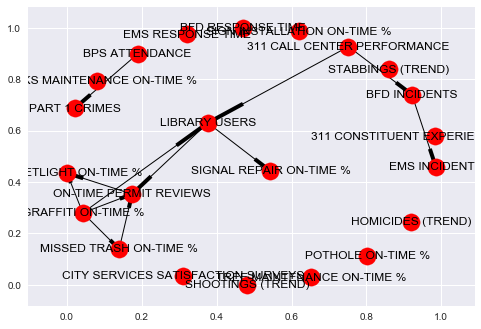

In [135]:
# generate a causal diagram
G = nx.DiGraph()
G.add_nodes_from(range(n))

# define "significant" correlations
corr_signif = [[(u,v),Corr.iloc[u,v]] 
               for u in range(n) for v in range(n) if abs(Corr.iloc[u,v]) > 0.3 and u < v]

corr_signif_names = [[(list(Corr)[u],list(Corr)[v]),Corr.iloc[u,v]] 
               for u in range(n) for v in range(n) if abs(Corr.iloc[u,v]) > 0.3 and u < v]
print('Significant correlations:',*corr_signif_names,sep='\n')

# generate a directed acyclic graph G to reflect this (there are at least 2 such DAGs)
corr_signif = np.array(corr_signif)
edges = corr_signif[:,0]
G.add_edges_from(edges)
print('Is this a DAG? ', nx.is_directed_acyclic_graph(G))

# relabel nodes and print graph
mapping=dict(zip(G.nodes(),Corr.columns))
H = nx.relabel_nodes(G,mapping)
nx.draw_networkx(H, with_labels=True) # using draw_networkx instead draw b

In [136]:
# get adjacency matrix from graph
Adj_list = nx.adjacency_matrix(G, weight=None)
Adj_matrix = Adj_list.todense()
Adj_df = pd.DataFrame(Adj_matrix, index=Corr.columns, columns=Corr.columns)
print('Table of causal relations (1 means row_var -> column_var):')
Adj_df

Table of causal relations (1 means row_var -> column_var):


CTY_SCR_NAME                        311 CALL CENTER PERFORMANCE  \
CTY_SCR_NAME                                                      
311 CALL CENTER PERFORMANCE                                   0   
311 CONSTITUENT EXPERIENCE SURVEYS                            0   
BFD INCIDENTS                                                 0   
BFD RESPONSE TIME                                             0   
BPS ATTENDANCE                                                0   
CITY SERVICES SATISFACTION SURVEYS                            0   
EMS INCIDENTS                                                 0   
EMS RESPONSE TIME                                             0   
GRAFFITI ON-TIME %                                            0   
HOMICIDES (TREND)                                             0   
LIBRARY USERS                                                 0   
MISSED TRASH ON-TIME %                                        0   
ON-TIME PERMIT REVIEWS                                        0   
PARKS MAINTENANCE ON-TIME %                                   0   
PART 1 CRIMES                                                 0   
POTHOLE ON-TIME %                                             0   
SHOOTINGS (TREND)                                             0   
SIGN INSTALLATION ON-TIME %                                   0   
SIGNAL REPAIR ON-TIME %                                       0   
STABBINGS (TREND)                                             0   
STREETLIGHT ON-TIME %                                         0   
TREE MAINTENANCE ON-TIME %                                    0   

CTY_SCR_NAME                        311 CONSTITUENT EXPERIENCE SURVEYS  \
CTY_SCR_NAME                                                             
311 CALL CENTER PERFORMANCE                                          0   
311 CONSTITUENT EXPERIENCE SURVEYS                                   0   
BFD INCIDENTS                                                        0   
BFD RESPONSE TIME                                                    0   
BPS ATTENDANCE                                                       0   
CITY SERVICES SATISFACTION SURVEYS                                   0   
EMS INCIDENTS                                                        0   
EMS RESPONSE TIME                                                    0   
GRAFFITI ON-TIME %                                                   0   
HOMICIDES (TREND)                                                    0   
LIBRARY USERS                                                        0   
MISSED TRASH ON-TIME %                                               0   
ON-TIME PERMIT REVIEWS                                               0   
PARKS MAINTENANCE ON-TIME %                                          0   
PART 1 CRIMES                                                        0   
POTHOLE ON-TIME %                                                    0   
SHOOTINGS (TREND)                                                    0   
SIGN INSTALLATION ON-TIME %                                          0   
SIGNAL REPAIR ON-TIME %                                              0   
STABBINGS (TREND)                                                    0   
STREETLIGHT ON-TIME %                                                0   
TREE MAINTENANCE ON-TIME %                                           0   

CTY_SCR_NAME                        BFD INCIDENTS  BFD RESPONSE TIME  \
CTY_SCR_NAME                                                           
311 CALL CENTER PERFORMANCE                     1                  0   
311 CONSTITUENT EXPERIENCE SURVEYS              0                  0   
BFD INCIDENTS                                   0                  0   
BFD RESPONSE TIME                               0                  0   
BPS ATTENDANCE                                  0                  0   
CITY SERVICES SATISFACTION SURVEYS              0                  0   
EMS INCIDENTS                         

In [137]:
# cartesian product
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

# create regression dataframe from causation, correlation dataframes
def integrate(causation_df, dependent_correlation_df):
    n = causation_df.shape[0]
    A = np.array(list(range(n)))
    B = cartesian_product(A,A)
    C = []
    
    # for (var1, var2) in upper-right corner of correlation matrix, 
    # append (is_causal, correlation ** 2), unless that entry of the 
    # correlation matrix is empty
    for u,v in B:
        if u < v and math.isnan(dependent_correlation_df.iat[u,v]) is False: # see remark in next markdown block
            C.append((max(causation_df.iat[v,u],causation_df.iat[u,v]),dependent_correlation_df.iat[u,v] ** 2))
    C = pd.DataFrame(C, columns=['Causation', 'Determination'])
    
    return C

**Remark:** note that the data set generated by integrate does not include: 
1. pairs of variables A, A on the diagonal
2. pairs A, B where we are missing the correlation. Clearly, we can't train without being given the true correlation.
3. both pairs (A,B) and (B,A). These are equivalent since we only care about the existence of a causal relation between A and B, not its direction. If there existed a causal relation of any likelihood, we then picked the max of either direction.

In [138]:
# prepare Causation x Determination dataset
C = integrate(Adj_df, Corr_dep)
causation = C['Causation']
determination = C['Determination']

# regr.fit() requires a 2d array for some reason, even though there is only 1 feature
causation = np.array(causation).reshape(-1, 1)

# record the correlation
corr = C.corr()
print('Size of dataset:', np.size(causation), 'examples')
print('The correlation between causation and determination is ', corr['Causation']['Determination'])

Size of dataset: 110 examples
The correlation between causation and determination is  0.809134027566


Coefficients: m =  [ 0.13240549] y =  0.0156618518238
Score:  0.654697874564


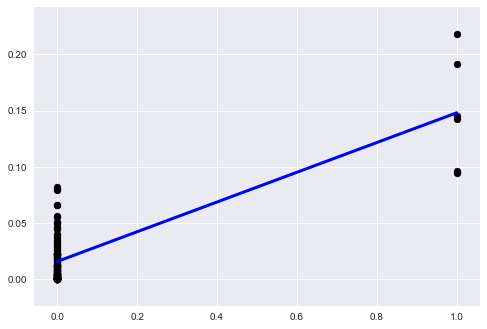

In [139]:
# generate simple regression model causation -> determination
from sklearn import linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model
regr.fit(causation,determination)

# The coefficients
print('Coefficients: m = ', regr.coef_, 'y = ', regr.intercept_)

print('Score: ', regr.score(causation, determination, sample_weight=None))

# Generate predictions on [0,1]
determination_predictions = regr.predict(np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).reshape(-1,1))

# Plot outputs
plt.scatter(causation, determination, color='black')
plt.plot(np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]), determination_predictions, color='blue', linewidth=3)

plt.show()

# With cheating + continuous variable

The next piece of code implements a continuous "causal" likelihood variable, using the following formula:

$$Caus'(A,B) = \sum_{ij} |\text{Corr}^*(A, v_i) \text{Caus}(v_i,v_j) \text{Corr}^*(v_j, B)|$$

where $N$ is the set of variables, $A,B \in N \times N$, and $$\text{Corr}^*(u,v) = \begin{cases} \text{Corr}(u,v) & \text{if not null} \\ 0 & \text{otherwise}\end{cases}$$.

In [140]:
# convert to a continuous likelihood variable using Adj_df and Missing

Adj_cont_df = Adj_df.copy().apply(pd.to_numeric, errors='ignore', downcast='float')

for A in range(0,n):
    for B in range(0,n):
        if (A != B):
            for i in range(0,n):
                if (math.isnan(Corr_dep.iat[A,i]) is False):
                    for j in range(0,n):
                        #if (i != j and Adj_df.iat[i,j] > 0):
                        if (i != j and Adj_df.iat[i,j] > 0 and math.isnan(Corr_dep.iat[j,B]) is False):
                            Adj_cont_df.iat[A,B] = Adj_cont_df.iat[A,B] + abs(1 * Corr_dep.iat[A,i] * Corr_dep.iat[j,B])

# I've replaced Adj_df.iat[i,j] with 1 in the bottom clause, and inserted the condition
# Adj_df.iat[i,j] > 0 above it. Later, we may want to put it back if we want to iterate
# the operation above with the new causal matrix.

# The i != j condition is since every Caus(i,i) = 0 (no self-loops)

# One corner of the causal matrix is entirely 0. This is a little surprising.
# Basically what it says is that, of that extant causal relations, there did not exist
# a single complete path A-corr-i-caus-j-corr-B from A to B. From testing, inserting
# even a single causal path into the lower right corner populated that entire corner.

# What about getting replacing the 0s in the matrix below with NaNs?

# normalize
unnormalized_maximum_likelihood_score = Adj_cont_df.max().max()
normalized_Adj_cont_df = Adj_cont_df.multiply(1/unnormalized_maximum_likelihood_score) 

normalized_Adj_cont_df

CTY_SCR_NAME                        311 CALL CENTER PERFORMANCE  \
CTY_SCR_NAME                                                      
311 CALL CENTER PERFORMANCE                            0.000000   
311 CONSTITUENT EXPERIENCE SURVEYS                     0.035468   
BFD INCIDENTS                                          0.131164   
BFD RESPONSE TIME                                      0.044038   
BPS ATTENDANCE                                         0.078369   
CITY SERVICES SATISFACTION SURVEYS                     0.044159   
EMS INCIDENTS                                          0.035610   
EMS RESPONSE TIME                                      0.065437   
GRAFFITI ON-TIME %                                     0.185534   
HOMICIDES (TREND)                                      0.056397   
LIBRARY USERS                                          0.182097   
MISSED TRASH ON-TIME %                                 0.000000   
ON-TIME PERMIT REVIEWS                                 0.000000   
PARKS MAINTENANCE ON-TIME %                            0.000000   
PART 1 CRIMES                                          0.000000   
POTHOLE ON-TIME %                                      0.000000   
SHOOTINGS (TREND)                                      0.000000   
SIGN INSTALLATION ON-TIME %                            0.000000   
SIGNAL REPAIR ON-TIME %                                0.000000   
STABBINGS (TREND)                                      0.000000   
STREETLIGHT ON-TIME %                                  0.000000   
TREE MAINTENANCE ON-TIME %                             0.000000   

CTY_SCR_NAME                        311 CONSTITUENT EXPERIENCE SURVEYS  \
CTY_SCR_NAME                                                             
311 CALL CENTER PERFORMANCE                                   0.071662   
311 CONSTITUENT EXPERIENCE SURVEYS                            0.000000   
BFD INCIDENTS                                                 0.059314   
BFD RESPONSE TIME                                             0.014077   
BPS ATTENDANCE                                                0.023148   
CITY SERVICES SATISFACTION SURVEYS                            0.013707   
EMS INCIDENTS                                                 0.017670   
EMS RESPONSE TIME                                             0.020238   
GRAFFITI ON-TIME %                                            0.045399   
HOMICIDES (TREND)                                             0.013595   
LIBRARY USERS                                                 0.046426   
MISSED TRASH ON-TIME %                                        0.000000   
ON-TIME PERMIT REVIEWS                                        0.000000   
PARKS MAINTENANCE ON-TIME %                                   0.000000   
PART 1 CRIMES                                                 0.000000   
POTHOLE ON-TIME %                                             0.000000   
SHOOTINGS (TREND)                                             0.000000   
SIGN INSTALLATION ON-TIME %                                   0.000000   
SIGNAL REPAIR ON-TIME %                                       0.000000   
STABBINGS (TREND)                                             0.000000   
STREETLIGHT ON-TIME %                                         0.000000   
TREE MAINTENANCE ON-TIME %                                    0.000000   

CTY_SCR_NAME                        BFD INCIDENTS  BFD RESPONSE TIME  \
CTY_SCR_NAME                                                           
311 CALL CENTER PERFORMANCE              0.756084           0.124863   
311 CONSTITUENT EXPERIENCE SURVEYS       0.037173           0.015881   
BFD INCIDENTS                            0.000000           0.059525   
BFD RESPONSE TIME                        0.062185           0.000000   
BPS ATTENDANCE                           0.133460           0.033999   
CITY SERVICES SATISFACTION SURVEYS       0.059774           0.019670   
EMS INCIDENTS                         

In [141]:
# compute the new regression model using the continuous variable

# prepare Causation x Determination dataset
C = integrate(normalized_Adj_cont_df, Corr_dep)
causation = C['Causation']
determination = C['Determination']

# regr.fit() requires a 2d array for some reason, even though there is only 1 feature
causation = np.array(causation).reshape(-1, 1)

# record the correlation
corr = C.corr()
print('Size of dataset:', np.size(causation), 'examples')
print('Continuous version: \n The correlation between causation and determination is ', 
      corr['Causation']['Determination'])

Size of dataset: 110 examples
Continuous version: 
 The correlation between causation and determination is  0.843170048981


Coefficients: m =  [ 0.19941564] y =  0.00507285361421
Score:  0.710935731499


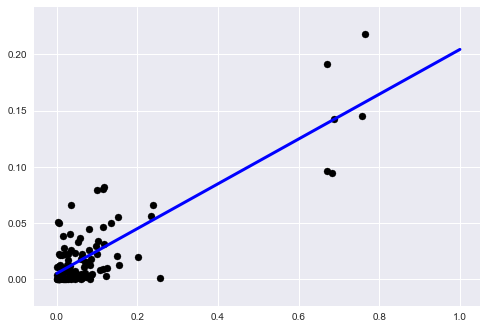

In [142]:
# Create linear regression object
regr2 = linear_model.LinearRegression()

# Train the model
regr2.fit(causation, determination)

# The coefficients
print('Coefficients: m = ', regr2.coef_, 'y = ', regr2.intercept_)

print('Score: ', regr2.score(causation, determination, sample_weight=None))

# Generate predictions on [0,1]
determination_predictions = regr2.predict(np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,
                                                    0.7,0.8,0.9,1]).reshape(-1,1))

# Plot outputs
plt.scatter(causation, determination, color='black')
plt.plot(np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]), 
         determination_predictions, color='blue', linewidth=3)

plt.show()

**Remark**: in the graph above, the reason there is no point such that p(is_causal) = 1 is because "integrate" throws away unordered pairs (var1, var2) that is missing a label, i.e. the correlation.

In [143]:
# One way to use this is to ask when you look at a continuous variable 
# is, I want to ----learn---- the optimal value for that continuous variable. But optimal for what
# In this case, I have a collection of continuous variables, one for every ordered pair of variables.
# This collection of continuous variables represents a weighted, directed graph. 
# Or the graph represents those variables.

In [144]:
# study the graph distance from discrete to continuous version
# use a random walk kernel
# the idea is to integrate the contribution across all variable-pairs

# I'm having a hard time importing the graphkernels library into Python. I'll come back to this later.

What's going on here?

One way to think about this is that we are moving the "graph variable" along a gradient, as determined by the "empirical" correlation (i.e. the ones we know). In other words, we are just learning a graph embedding.

An abstract version of "path-blocking".

This feels like it might be a special coase of one already does in learning. "I'm given some data. Translate the feature space using the known labels..."

# Sokwoo's causation matrix

Experiments using Sokwoo's causation matrix.

Each entry below represents the likelihood of there being a causal relationship from the column variable to the row variable, measured from -10 to 10, where -10 means "I'm certain there is no causal relationship" and 10 means "I'm certain there is a causal relationship". 0 means "I don't know either way."

In [147]:
Caus

Does there exist a causal relation from COLUMN to ROW?  311 CALL CENTER PERFORMANCE  \
311 CALL CENTER PERFORMANCE                                                      10   
311 CONSTITUENT EXPERIENCE SURVEYS                                               -5   
BFD INCIDENTS                                                                    -9   
BFD RESPONSE TIME                                                                -8   
BPS ATTENDANCE                                                                   -8   
CITY SERVICES SATISFACTION SURVEYS                                              -10   
EMS INCIDENTS                                                                    -8   
EMS RESPONSE TIME                                                                -9   
GRAFFITI ON-TIME %                                                               -9   
HOMICIDES (TREND)                                                                -9   
LIBRARY USERS                                                                    -9   
MISSED TRASH ON-TIME %                                                           -9   
ON-TIME PERMIT REVIEWS                                                           -9   
PARKS MAINTENANCE ON-TIME %                                                      -9   
PART 1 CRIMES                                                                    -9   
POTHOLE ON-TIME %                                                                -9   
SHOOTINGS (TREND)                                                                -9   
SIGN INSTALLATION ON-TIME %                                                      -9   
SIGNAL REPAIR ON-TIME %                                                          -9   
STABBINGS (TREND)                                                                -9   
STREETLIGHT ON-TIME %                                                            -9   
TREE MAINTENANCE ON-TIME %                                                       -9   

Does there exist a causal relation from COLUMN to ROW?  311 CONSTITUENT EXPERIENCE SURVEYS  \
311 CALL CENTER PERFORMANCE                                                              9   
311 CONSTITUENT EXPERIENCE SURVEYS                                                      10   
BFD INCIDENTS                                                                           -6   
BFD RESPONSE TIME                                                                       -2   
BPS ATTENDANCE                                                                          -9   
CITY SERVICES SATISFACTION SURVEYS                                                     -10   
EMS INCIDENTS                                                                           -9   
EMS RESPONSE TIME                                                                       -8   
GRAFFITI ON-TIME %                                                                      -9   
HOMICIDES (TREND)                                                                       -9   
LIBRARY USERS                                                                           -9   
MISSED TRASH ON-TIME %                                                                  -9   
ON-TIME PERMIT REVIEWS                                                                  -9   
PARKS MAINTENANCE ON-TIME %                                                             -9   
PART 1 CRIMES                                                                           -9   
POTHOLE ON-TIME %                                                                       -9   
SHOOTINGS (TREND)                                                                       -9   
SIGN INSTALLATION ON-TIME %                                                             -9   
SIGNAL REPAIR ON-TIME %                                                                 -9   
STABBINGS (TREND)                                                                       -9   
STREETLIGHT ON-TIME %   

Continuous version: 
 The correlation between causation and determination is  -0.0910013888268
Coefficients: m =  [-0.00055507] y =  0.0201237807334
Score:  0.0082812527684


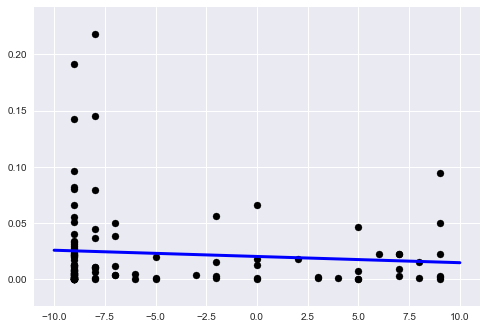

In [148]:
# compute model for the Caus input

# prepare Causation x Determination dataset
A = np.array(list(range(n)))
B = cartesian_product(A,A)
C = []

# for (var1, var2), compute (is_causal, correlation ** 2) for the dataset X
for u,v in B:
    if u < v and math.isnan(Corr_dep.iat[u,v]) is False: # see remark in next markdown block
        C.append((max(Caus.iat[u,v],Caus.iat[v,u]),
                  Corr_dep.iat[u,v] ** 2))

# convert to DataFrame
C = pd.DataFrame(C, columns=['Causation', 'Determination'])
causation = C.iloc[:,0]
determination = C.iloc[:,1]

# regr.fit() requires a 2d array for some reason, even though there is only 1 feature
causation = np.array(causation).reshape(-1, 1)

# record the correlation
corr = C.corr()
print('Continuous version: \n The correlation between causation and determination is ', 
      corr['Causation']['Determination'])

# Create linear regression object
regr3 = linear_model.LinearRegression()

# Train the model
regr3.fit(causation, determination)

# The coefficients
print('Coefficients: m = ', regr3.coef_, 'y = ', regr3.intercept_)

print('Score: ', regr3.score(causation, determination, sample_weight=None))

# Generate predictions on [0,1]
determination_predictions = regr3.predict(np.array([-10,0,0.1,0.2,0.3,0.4,0.5,0.6,
                                                    0.7,0.8,0.9,1,10]).reshape(-1,1))

# Plot outputs
plt.scatter(causation, determination, color='black')
plt.plot(np.array([-10,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,10]), 
         determination_predictions, color='blue', linewidth=3)

plt.show()

As you can tell, this is problematic: it seems there is no correlation (and even a slightly negative correlation) between causal information supplied by an expert, and the actual, recorded correlations.

We can also try to take out some of the columns in the data. But which? Only the original expert (in this case, Sokwoo) can really go back and edit the data in this way. I can't just start removing columns / rows based on how that helps my prediction error.

Let's graph it out, to see what the diagram looks like. In the block below, I use a threshold of 5 to construct the adjacency matrix of a directed graph; anything below 5 is 0, anything 5 and above is 1 (there is an edge).

In [149]:
# convert causation matrix into {0,1}-adjacency matrix 

A = np.array(list(range(n)))
B = cartesian_product(A,A)
Caus_adj = Caus.copy()

for u,v in B:
    if Caus_adj.iat[u,v] < 5:
        Caus_adj.iat[u,v] = 0
    else: Caus_adj.iat[u,v] = 1

Caus_adj

Does there exist a causal relation from COLUMN to ROW?  311 CALL CENTER PERFORMANCE  \
311 CALL CENTER PERFORMANCE                                                       1   
311 CONSTITUENT EXPERIENCE SURVEYS                                                0   
BFD INCIDENTS                                                                     0   
BFD RESPONSE TIME                                                                 0   
BPS ATTENDANCE                                                                    0   
CITY SERVICES SATISFACTION SURVEYS                                                0   
EMS INCIDENTS                                                                     0   
EMS RESPONSE TIME                                                                 0   
GRAFFITI ON-TIME %                                                                0   
HOMICIDES (TREND)                                                                 0   
LIBRARY USERS                                                                     0   
MISSED TRASH ON-TIME %                                                            0   
ON-TIME PERMIT REVIEWS                                                            0   
PARKS MAINTENANCE ON-TIME %                                                       0   
PART 1 CRIMES                                                                     0   
POTHOLE ON-TIME %                                                                 0   
SHOOTINGS (TREND)                                                                 0   
SIGN INSTALLATION ON-TIME %                                                       0   
SIGNAL REPAIR ON-TIME %                                                           0   
STABBINGS (TREND)                                                                 0   
STREETLIGHT ON-TIME %                                                             0   
TREE MAINTENANCE ON-TIME %                                                        0   

Does there exist a causal relation from COLUMN to ROW?  311 CONSTITUENT EXPERIENCE SURVEYS  \
311 CALL CENTER PERFORMANCE                                                              1   
311 CONSTITUENT EXPERIENCE SURVEYS                                                       1   
BFD INCIDENTS                                                                            0   
BFD RESPONSE TIME                                                                        0   
BPS ATTENDANCE                                                                           0   
CITY SERVICES SATISFACTION SURVEYS                                                       0   
EMS INCIDENTS                                                                            0   
EMS RESPONSE TIME                                                                        0   
GRAFFITI ON-TIME %                                                                       0   
HOMICIDES (TREND)                                                                        0   
LIBRARY USERS                                                                            0   
MISSED TRASH ON-TIME %                                                                   0   
ON-TIME PERMIT REVIEWS                                                                   0   
PARKS MAINTENANCE ON-TIME %                                                              0   
PART 1 CRIMES                                                                            0   
POTHOLE ON-TIME %                                                                        0   
SHOOTINGS (TREND)                                                                        0   
SIGN INSTALLATION ON-TIME %                                                              0   
SIGNAL REPAIR ON-TIME %                                                                  0   
STABBINGS (TREND)                                                                        0   
STREETLIGHT ON-TIME %   

Is this a DAG?  False


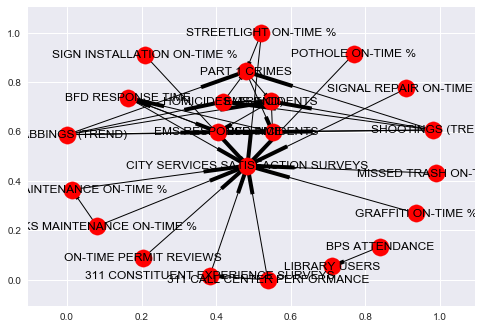

In [124]:
# construct DAG

S = nx.DiGraph()
S.add_nodes_from(range(n))
mapping=dict(zip(S.nodes(),Corr.columns))
S = nx.relabel_nodes(S,mapping)

# convert list of edges from Sokwoo's causation matrix into an array

edges = []
for u in range(n):
    for v in range (n):
        if Caus_adj.iat[u,v] == 1:
            edges.append((Caus_adj.columns[u], Caus_adj.index[v]))
S.add_edges_from(edges)
print('Is this a DAG? ', nx.is_directed_acyclic_graph(S))

# relabel nodes and print graph
nx.draw_networkx(S, with_labels=True) # using draw_networkx instead draw b

# Structural experiments

Now we'll try to dig in and extract more information from our causal matrix.

In [150]:
# define structural identity
# is there a better way of doing this; can we say that these numbers are numerical invariants
# defined on the objects (or morphisms) of some category?

# paths_between
paths_between = []

print('Source: LIBRARY USERS, Target: ON-TIME PERMIT REVIEWS')

def all_paths(graph, source, target):
    paths = []
    for path in nx.all_simple_paths(graph, source, target, cutoff=None):
        paths.append(path)
    return paths

print('Number of paths:', len(all_paths(H, 'LIBRARY USERS', 'ON-TIME PERMIT REVIEWS')))

# forks_between
# for all other nodes, does there exist paths from that node to A, B? If so, add to list.

def all_forks(graph, node1, node2):
    forks = []
    for node in graph.nodes():
        if nx.has_path(graph, node, node1) and nx.has_path(graph, node, node2):
            forks.append(node)
    return forks

print('Number of forks:', len(all_forks(H, 'LIBRARY USERS', 'ON-TIME PERMIT REVIEWS')))

# colliders_between
# for all other nodes, does there exist paths to that node from A, B? If so, add to list.

def all_colliders(graph, node1, node2):
    colliders = []
    for node in graph.nodes():
        if nx.has_path(graph, node1, node) and nx.has_path(graph, node2, node):
            colliders.append(node)
    return colliders

print('Number of colliders:', len(all_colliders(H, 'LIBRARY USERS', 'ON-TIME PERMIT REVIEWS')))

Source: LIBRARY USERS, Target: ON-TIME PERMIT REVIEWS
Number of paths: 1
Number of forks: 3
Number of colliders: 2


**Remark**: instead of constructing these #s directly from the causal diagram, can you do it in a more "principled" way by going through Caus[C] (for some compact closed category C of mathematical models) of "causal" mathematical models? I.e. a functor from Caus[C] to some setting like Ab. Side question: can C encompass heterogeneous models?

**Remark**: the reality is, the #s above will probably not give you that much additional information, at least, information that's relevant for guessing a correlation. HOWEVER, this sort of information IS useful for figuring out whether a given *or predicted* correlation is spurious! You can ask things like. Basically, it's a "little world" within which you can do statistics and causal inference.

**Remark**: alternately you could try to make up a category of such DAGs, or use Fong's causal theory. But Caus[C] may be useful in that it's very explicit about what sort of processes can satisfy the causal DAGs.

In [151]:
# create expanded regression dataframe with path, fork, and collider variables
def integrate_plus(causation_df, dependent_correlation_df, graph):
    n = causation_df.shape[0]
    A = np.array(list(range(n)))
    B = cartesian_product(A,A)
    C = []
    
    # for (var1, var2) in upper-right corner of correlation matrix, 
    # append (is_causal, correlation ** 2), unless that entry of the 
    # correlation matrix is empty
    for u,v in B:
        if u < v and math.isnan(dependent_correlation_df.iat[u,v]) is False:
            C.append((max(causation_df.iat[u,v],causation_df.iat[v,u]), # max over both directions
                      max(len(all_paths(graph, dependent_correlation_df.columns[u],dependent_correlation_df.columns[v])), len(all_paths(graph, dependent_correlation_df.columns[v],dependent_correlation_df.columns[u]))),  # max over both directions
                      len(all_forks(graph,dependent_correlation_df.columns[u],dependent_correlation_df.columns[v])), 
                      len(all_colliders(graph,dependent_correlation_df.columns[u],dependent_correlation_df.columns[v])),
                      dependent_correlation_df.iat[u,v] ** 2))
    C = pd.DataFrame(C, columns=['Causation', 'Paths', 'Forks', 'Colliders', 'Determination'])
    
    return C

In [152]:
# prepare new causation + paths + forks + colliders info, determination

C  = integrate_plus(normalized_Adj_cont_df, Corr_dep, H)

# convert to DataFrame
causation = C.iloc[:,0]
paths = C.iloc[:,1]
forks = C.iloc[:,2]
colliders = C.iloc[:,3]
determination = C.iloc[:,4]

# record the correlation
corr = C.corr()

corr

Causation     Paths     Forks  Colliders  Determination
Causation       1.000000  0.893178  0.609360   0.770053       0.843170
Paths           0.893178  1.000000  0.645923   0.711343       0.718376
Forks           0.609360  0.645923  1.000000   0.347157       0.437932
Colliders       0.770053  0.711343  0.347157   1.000000       0.679262
Determination   0.843170  0.718376  0.437932   0.679262       1.000000

In [169]:
X

[(0.071662388741970062, 0, 0, 0),
 (0.75608360767364502, 1, 1, 2),
 (0.12486299872398376, 0, 0, 0),
 (0.099859394133090973, 0, 0, 0),
 (0.11571177095174789, 0, 0, 0),
 (0.25577571988105774, 1, 1, 1),
 (0.15165646374225616, 0, 0, 0),
 (0.20054319500923157, 0, 0, 4),
 (0.056397207081317902, 0, 0, 0),
 (0.7656359076499939, 1, 1, 4),
 (0.059314269572496414, 0, 0, 0),
 (0.01588124968111515, 0, 0, 0),
 (0.023148301988840103, 0, 0, 0),
 (0.014841016381978989, 0, 0, 0),
 (0.032619230449199677, 0, 0, 0),
 (0.020238498225808144, 0, 0, 0),
 (0.045399483293294907, 0, 0, 0),
 (0.013594751246273518, 0, 0, 0),
 (0.068791143596172333, 0, 0, 0),
 (0.062185075134038925, 0, 0, 0),
 (0.13346002995967865, 0, 0, 0),
 (0.08446492999792099, 0, 0, 0),
 (0.68257451057434082, 1, 2, 1),
 (0.11408337950706482, 0, 0, 0),
 (0.14985229074954987, 0, 0, 0),
 (0.084189817309379578, 0, 0, 0),
 (0.23941372334957123, 0, 1, 0),
 (0.033998530358076096, 0, 0, 0),
 (0.021010236814618111, 0, 0, 0),
 (0.063434109091758728, 0, 0,

So causation, the # of paths, the # of forks, the # of colliders, and even determiniation are all relatively correlated with each other, at least in our fake causal diagram. That's a bit surprising, to be honest. I think this is an artifact of how we generated the "fake" diagram. Though we'll see later that Sokwoo's diagram also reproduces many of these same correlations (though not the most important one, i.e. the ones with the determination!). 

In [191]:
# construct multiple regression model

# Create linear regression object
regr3 = linear_model.LinearRegression()
X = list(zip(causation,paths,forks,colliders))
y = list(C['Determination'].values)
#y = np.asarray(y).reshape(len(y), 1)
# Train the model
regr3.fit(X, y)

# The coefficients
print('Coefficients: m = ', regr3.coef_, 'y = ', regr3.intercept_)

print('Score: ', regr3.score(X, y, sample_weight=None))

predictions = []
for row in X:
    predictions.append(regr3.predict([(row[0],row[1],row[2],row[3])]))

error3 = metrics.mean_absolute_error(predictions, C['Determination'].values)
r2_3 = metrics.r2_score(predictions, C['Determination'].values)

print('The mean absolute error on cheating diagram + continuos variable is', error3)
print('The R2 score on cheating diagram + continuous variable is', r2_3)
# Generate predictions on [0,1]
#determination_predictions = regr3.predict(np.array([-10,0,0.1,0.2,0.3,0.4,0.5,0.6,
#                                                    0.7,0.8,0.9,1,10]).reshape(-1,1))

# Plot outputs
#plt.scatter(X, y, color='black')
#plt.plot(np.array([-10,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,10]), 
#         determination_predictions, color='blue', linewidth=3)

#plt.show()

Coefficients: m =  [ 0.23039757 -0.01912632 -0.004573    0.0028484 ] y =  0.0041765149573
Score:  0.723927969819
The mean absolute error on cheating diagram + continuos variable is 0.0141737112758
The R2 score on cheating diagram + continuous variable is 0.618647100691


Again, the R2 score is marginally better for this new feature space. But we're not really using the extra features "intelligently", just insofar as they correlated with the correlation.

In [126]:
# prepare new data set for Sokwoo's causation matrix and the corresponding graph S

C  = integrate_plus(Caus, Corr_dep, S)

causation = C.iloc[:,0]
paths = C.iloc[:,1]
forks = C.iloc[:,2]
colliders = C.iloc[:,3]
determination = C.iloc[:,4]

# record the correlation
corr = C.corr()

corr

Causation     Paths     Forks  Colliders  Determination
Causation       1.000000  0.439851  0.658058   0.607804      -0.091001
Paths           0.439851  1.000000  0.557619   0.270750      -0.098809
Forks           0.658058  0.557619  1.000000   0.304419      -0.034537
Colliders       0.607804  0.270750  0.304419   1.000000      -0.136502
Determination  -0.091001 -0.098809 -0.034537  -0.136502       1.000000

While the correlations between paths, forks, and colliders remain mostly same, note that there is a significantly weaker correlation between the # of paths and the existence of a direct causal relationship a.k.a. 1-step paths (okay, that's fine if there are many more longer paths as a portion of all paths), and a signficantly weaker correlation between the number of colliders and the number of paths.

In [ ]:
# TO DO: construct multiple regression for Sokwoo's diagram + discrete



In [21]:
# define d-separation feature (i.e. how the absence of an edge works) aka causal independence

In [18]:
# define continuous version of structural identity?

In [22]:
# "run over multiple diagrams"
# locally act like you're working in a DAG; globally you aren't though
# is there a local-global thing? what should "gluing" look like?

If I wanted to input different kinds of mathematical models like dynamical systems or quantum computations which happen to have semantics in some symmetric monoidal compact closed category C with discarding and some technical conditions on second-order causal processes. Then I can translate my DAG into a morphism in Caus[C].

How does this help me? Maybe it helps me because what I really want is some way of integrating a whole bunch of scientific models, which really mean 2 things: breadth, i.e. many models of the same type but over different domains being integrated together, and depth, i.e. many models of different types over the same domain (i.e. a causal diagram as well as a dynamical system model over a portion of the variables, a quantum machine connecting other portions of the variables). This could possibly help with the second thing.

## Errors

Given $h : N \times N \to [0,1]$, the mean absolute error is defined by

$$\hat R(h) = \sum_{ij} |\text{Corr}(v_i,v_j)^2 - h(v_i, v_j)| $$

Given a full causation matrix as input, we will not use pairs (A,B) on the diagonal, and for pairs (A,B), (B,A) we will only use the value with the higher causal likelihood.

See http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics for more options. For example, sklearn.metrics.r2_score().

In [145]:
# construct set of predictions and return as dataframe
def predict(regr, causation_df, correlation_df):
    n = causation_df.shape[0]
    C = []
    
    for u in range(n):
        for v in range(n):
            if u < v and math.isnan(correlation_df.iat[u,v]) is False:
                max_likelihood = max(causation_df.iat[v,u],causation_df.iat[u,v])
                C.append((max_likelihood, 
                          regr.predict(max_likelihood)[0],
                          correlation_df.iat[u,v] ** 2))
    C = pd.DataFrame(C, columns=['Causation', 'Prediction', 'Determination'])
    return C

In [146]:
# calculate prediction errors

from sklearn import metrics

C1 = predict(regr, Adj_df, Corr)
error1 = metrics.mean_absolute_error(C1['Prediction'].values, C1['Determination'].values)
r2_1 = metrics.r2_score(C1['Prediction'].values, C1['Determination'].values)

C2 = predict(regr2, normalized_Adj_cont_df, Corr)
error2 = metrics.mean_absolute_error(C2['Prediction'].values, C2['Determination'].values)
r2_2 = metrics.r2_score(C2['Prediction'].values, C2['Determination'].values)

print('The mean absolute error on cheating + discrete variable is', error1)
print('The R2 score on cheating + discrete variable is', r2_1)
print('\n')
print('The mean absolute error on cheating + continuous variable is', error2)
print('The R2 score on cheating + continuous variable is', r2_2)
print('\n')
print('The average prediction error on Sokwoo + discrete variable is', )

The mean absolute error on cheating + discrete variable is 0.0158561468756
The R2 score on cheating + discrete variable is 0.469678852517


The mean absolute error on cheating + continuous variable is 0.01463966847
The R2 score on cheating + continuous variable is 0.646708821428


The average prediction error on Sokwoo + discrete variable is
